### ANALISIS EXPLORATORIO DE DATOS

In [74]:
#from google.colab import drive
#drive.mount('/content/drive')

Definición de librerías del proyecto

In [485]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import numpy as np
from numpy import NaN
from datetime import date, datetime, timedelta
from os import name


Definición de parámetros iniciales

In [246]:
NUM_OF_WEEK = 8.0
HOURS_OF_DAY = 24
DAYS_OF_WEEK = 7
FORMAT_DATE = '%Y-%m-%d'
DATE_START_TRAINIG = pd.to_datetime("2022-04-13", format=FORMAT_DATE)
FICHERO_DATA = './data/SERVICIO_UNIFICADO_2022.parquet.gzip'

Se cargan los datos en el dataFrame

In [247]:
#Se lee el archivo de un parquet a un dataframe
df_taxis = pd.read_parquet(FICHERO_DATA) 
#Se visualizan los datos
df_taxis.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,7,19
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,7,19
2,70152582,76001,9243481.0,3147558713,3.367783,NaN,-76.531083,NaN,ABANDONADO,APP,2022-04-30 19:00:01,7,19
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,7,19
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,7,19


Se valida cuantos valores nulos tenemos en el dataset

In [248]:
#Contar cuantos datos se encuentran nulos
df_taxis.isnull().sum()

ID                       0
IDCIUDAD                 0
USUARIO               1707
TELEFONOORIGEN       69322
LATITUD                  0
LATITUDDESTINO     1932690
LONGITUD                 0
LONGITUDDESTINO    1932690
ESTADO                   0
ORIGEN                   0
FECHACOMPLETA            0
DIADESEMANA              0
HORA                     0
dtype: int64

Se limpian los datos donde el teléfono del usuario es nulo
 para tener usuarios validos

In [249]:
#Se eliminan los registros donde el teléfono de origen sea nulo
df_taxis = df_taxis[~df_taxis['TELEFONOORIGEN'].isnull()]

Se limitan los datos a la ciudad de bogotá

In [250]:
#Se filtra el dataset solo para la ciudad de bogotá
df_taxis = df_taxis[df_taxis["IDCIUDAD"]==11001]

Se limitan los canales por donde se reciben servicios a APP, IVR, CHATBOT, RECEPCIÓN, CALLE Y WEB que son los más relevantes.

In [251]:
df_taxis = df_taxis[(df_taxis["ORIGEN"]=="APP") | (df_taxis["ORIGEN"]=="IVR") | (df_taxis["ORIGEN"]=="CHAT_BOT_659") | (df_taxis["ORIGEN"]=="RECEPCION") | (df_taxis["ORIGEN"]=="CALLE") | (df_taxis["ORIGEN"]=="WEB")]

Se limitan los estados a ABANDONADO, CUMPLIDO, CANCELADO Y FINALIZADO que son los validos, el restos son errores del proceso.

In [252]:
df_taxis = df_taxis[(df_taxis["ESTADO"]=="ABANDONADO") | (df_taxis["ESTADO"]=="CUMPLIDO") | (df_taxis["ESTADO"]=="CANCELADO") | (df_taxis["ESTADO"]=="FINALIZADO")]

Se crean los campos de fecha sin la hora y el día de la semana

In [253]:
service_date = pd.to_datetime(df_taxis['FECHACOMPLETA'], format='%Y/%m/%d %H:%M:%S')
#Se crea un nuevo campo con la fecha en formato YYYY/MM/DD
df_taxis['FECHA'] = service_date.dt.strftime(FORMAT_DATE)
#Se crea un nuevo campo con el mes
df_taxis['MES'] = service_date.dt.month
#Se crea un nuevo campo con el día de la semana al que pertenece
df_taxis['DIADESEMANA'] = service_date.map( lambda x: x.isoweekday() )

Se visualizan los datos del dataFrame en un histograma

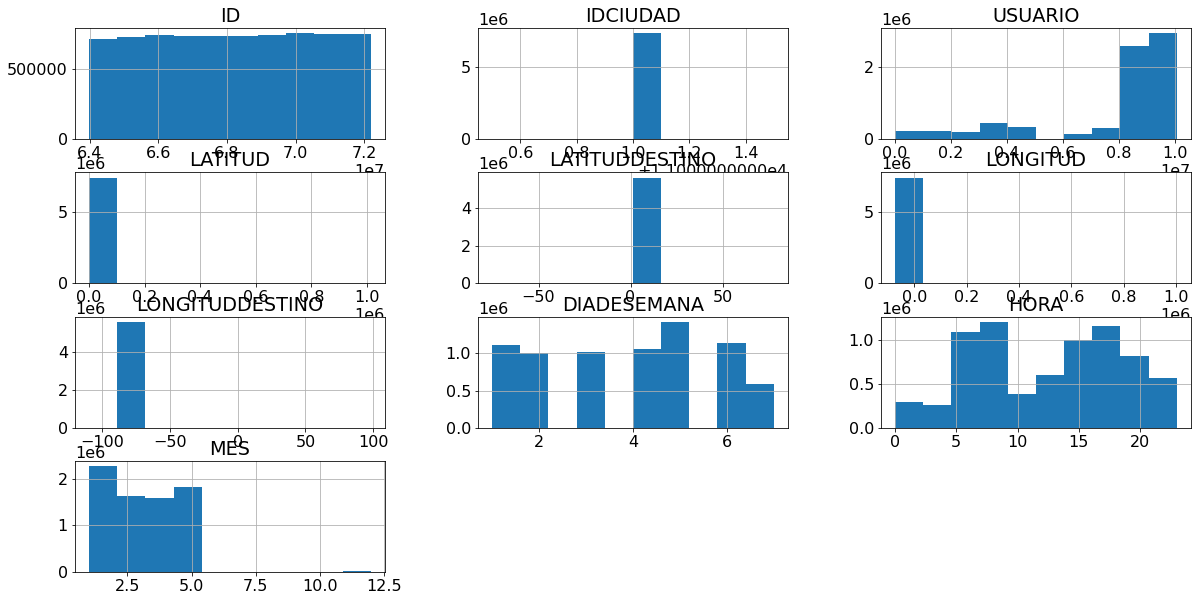

In [254]:
#Se require presentar gráfica de histograma por cada columna o datos de dataframe
df_taxis.hist(figsize=(20,10))
plt.show()

Se visualizan las corelaciones entre variables

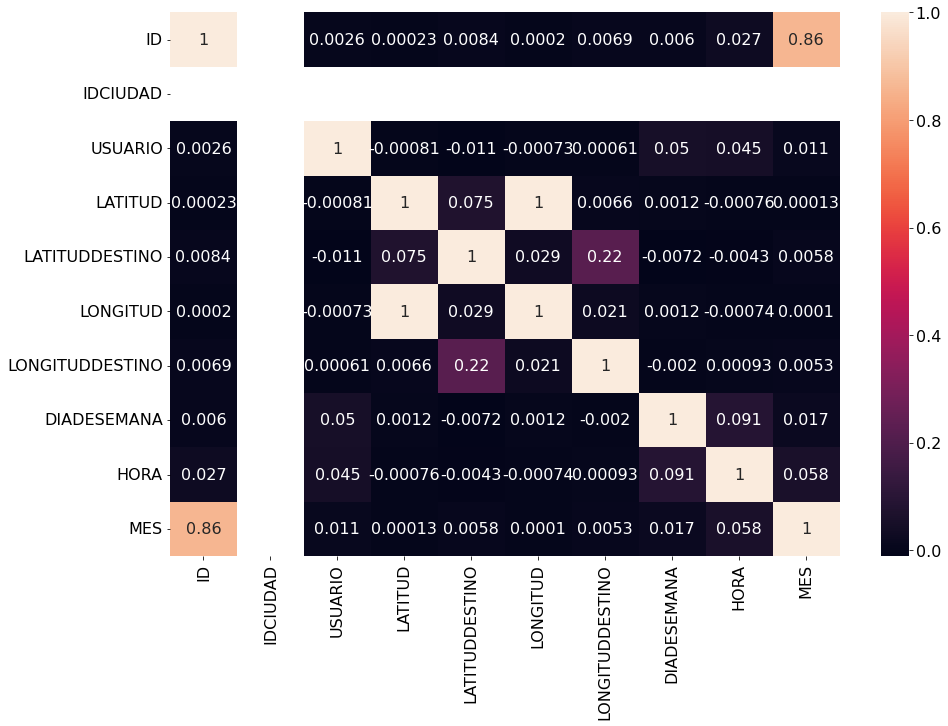

In [255]:
plt.figure(figsize=(15,10))
sns.heatmap(df_taxis.corr(method='pearson'),annot=True)

plt.show()

Se eliminan los datos que no se necesitan para predecir el modelo

In [256]:
#Eliminamos las columan que no son útiles para el modelo
df_taxis = df_taxis.drop(columns=["IDCIUDAD","USUARIO","ID","LATITUDDESTINO","LONGITUDDESTINO","LATITUD","LONGITUD","FECHACOMPLETA","ORIGEN","ESTADO"])
#Se eliminan los valores duplicados del dataframe y se ordenan por los campos más relevangtes
df_taxis = df_taxis.drop_duplicates().sort_values(by=['TELEFONOORIGEN','FECHA','DIADESEMANA','HORA'])
#Se reindexa nuevamente el dataFrame
df_taxis = df_taxis.reset_index(drop=True)
#Se visualizan como queda el dataFrame
df_taxis.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA,MES
0,+130047610,5,8,2022-04-29,4
1,+130055764,2,7,2022-04-12,4
2,+130055764,2,12,2022-04-12,4
3,+130153273,6,12,2022-02-05,2
4,+130153273,6,21,2022-05-28,5


Se contabilizan cuantos servicios tiene asignado un teléfono después de eliminar los duplicados

In [257]:
count_data = df_taxis.loc[:,['TELEFONOORIGEN']].value_counts()
count_data

TELEFONOORIGEN
3107584482        783
3138647901        684
3153865158        684
3134579964        642
13148180          628
                 ... 
3125329815          1
3125330004          1
3125330436          1
3125330453          1
999883673           1
Length: 517850, dtype: int64

Se observa la distribución de los datos

In [258]:
#Se visualizan los valores de los datos
count_data.describe()

count    517850.000000
mean          6.873261
std          15.002049
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max         783.000000
dtype: float64

Se calcula el outlayer de los datos

In [259]:
#Se calcula el quartil 25
q25 = count_data.quantile(0.25)
#Se calcula el quartil 75
q75 = count_data.quantile(0.75)
#Se calcula el rango inter quartil
iqr = q75 - q25

print(f"El porcentaje del quartil 25: {q25}")
print(f"El porcentaje del quartil 75: {q75}")
print(f"El rango inter quartil es: {iqr}")

El porcentaje del quartil 25: 1.0
El porcentaje del quartil 75: 6.0
El rango inter quartil es: 5.0


Se calcula el umbral de los valores atípicos

In [260]:
#Se calcula el umbral de los  valores atípicos
outliers_threshold = ( q75 + 3 * iqr )
print(f"El umbral de los valores atípicos es: {outliers_threshold}")
print(f"La cantidad de valores atípicos son: {sum(count_data > outliers_threshold) }")

El umbral de los valores atípicos es: 21.0
La cantidad de valores atípicos son: 36290


Eliminamos los datos que esten por debajo del umbral de los valores atípicos

In [261]:
df_cleaned = df_taxis.copy()
#Se descartan los que tienen menos del umbral de los valores atípicos
df_cleaned = df_cleaned.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > outliers_threshold)
#Se visualizan los datos agrupados por mes para determinar cuantos servicios tomó un usuario
df_cleaned.groupby(['MES','TELEFONOORIGEN'])['TELEFONOORIGEN'].count()

MES  TELEFONOORIGEN
1    0000000000        107
     12009954            6
     12013202           39
     12015158            2
     12029455            1
                      ... 
12   3508047744          1
     3508213441          2
     3508301213          1
     3508374630          2
     6051414             1
Name: TELEFONOORIGEN, Length: 169585, dtype: int64

In [262]:
#Se visualizan los valores de los datos
df_cleaned.loc[:,['TELEFONOORIGEN']].value_counts().describe()

count    36290.000000
mean        47.244172
std         34.939503
min         22.000000
25%         27.000000
50%         35.000000
75%         54.000000
max        783.000000
dtype: float64

In [263]:
#Se visualiza la cantidad de registros
df_cleaned.shape

(1714491, 5)

Transformamos el valor de origen y estado a no ordinales con onehot.

In [128]:
# convertimos a  onehot la comuna de origen
#df = pd.get_dummies(df, columns=["ORIGEN"])
# convertimos a  onehot la comuna de estado
#df = pd.get_dummies(df, columns=["ESTADO"])
"""new_df['ORIGEN'] = new_df['ORIGEN'].map( {
        "APP":1,
        "CALLE":2,
        "CHAT_BOT_659":3,
        "CHAT_BOT_689":4,
        "CHAT_BOT_729":5,
        "CHAT_BOT_803":6,
        "EXTERNO":7,
        "IONTAXI":8,
        "IVR":9,
        "NUEVO":10,
        "RECEPCION":11,
        "RED AMARILLA":12,
        "Reserva":13,
        "TELEGRAMTD":14,
        "WEB":15
    } )

new_df['ESTADO'] = new_df['ESTADO'].map( {
        "ABANDONADO":1,
        "ABORDOCONFIRMADO":2,
        "ALFRENTE":3,
        "ASIGNADO": 4,
        "CANCELADO":5,
        "CONFIRMADO":6,
        "CUMPLIDO":7,
        "FINALIZADO": 8,
        "LOCUCION":9,
        "NUEVO":10,
        "RECHAZADO":11
    } )"""
df_cleaned.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA,MES
68,0000000000,5,19,2021-12-31,12
69,0000000000,5,21,2021-12-31,12
70,0000000000,5,22,2021-12-31,12
71,0000000000,6,0,2022-01-01,1
72,0000000000,6,1,2022-01-01,1


### VISUALIZACIÓN DE DATOS

* Gráfico de dispersión de las variables
* Gráfico de distribución de las variables (Baja distribución, Baja predicción)
* Gráficas de correlación (Mapa de calor)

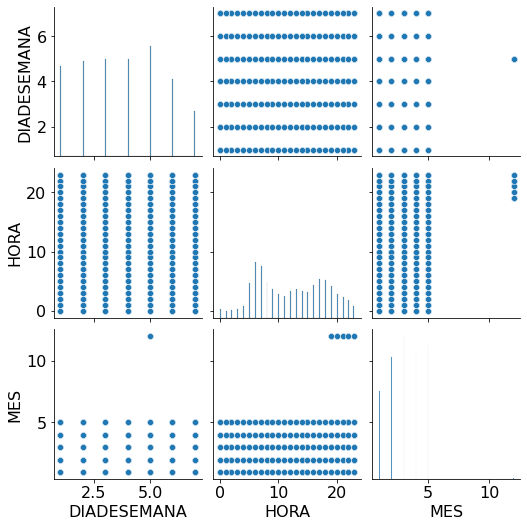

In [264]:
#Se presenta un gráfico general de los datos
sns.pairplot(df_cleaned)
plt.show()

In [265]:
corr_matrix = df_cleaned.corr()
corr_matrix

,DIADESEMANA,HORA,MES
DIADESEMANA,1.000000,0.042726,0.017200
HORA,0.042726,1.000000,0.012006
MES,0.017200,0.012006,1.000000


Text(0.5, 64.0, 'X')

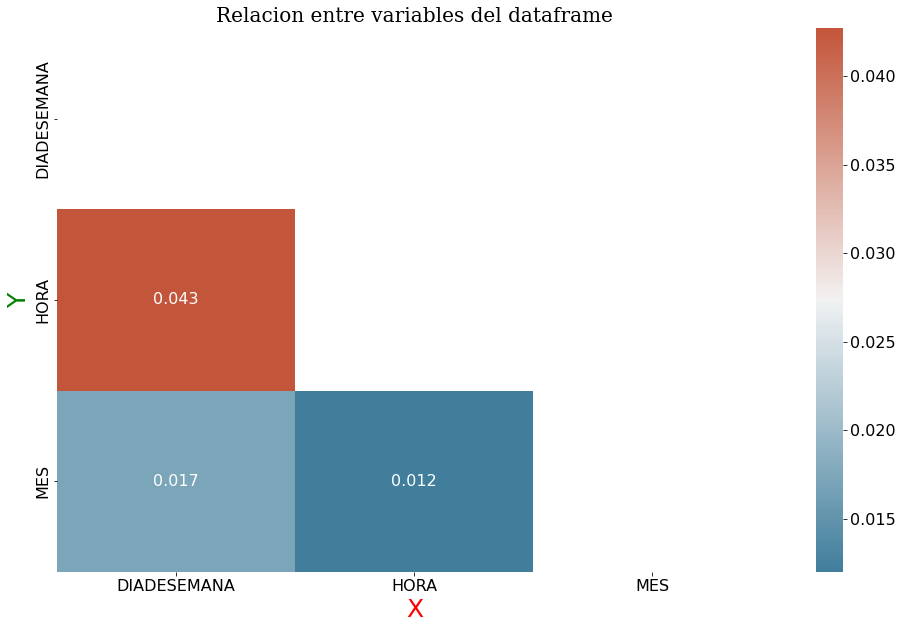

In [276]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap )
plt.title('Relacion entre variables del dataframe',fontsize=20,fontname='serif')
plt.ylabel('Y', color='green', fontsize=25)
plt.xlabel('X', color='Red', fontsize=25)

### EXPERIMENTOS CON DIFERENTES ENTRENAMIENTOS

In [267]:
#Función que permite identificar si en una fila hay un registro en la hora y en el día
def findRow(pdate, phour, data):
  for row in data:
    if( ( row[3] == pdate.strftime(FORMAT_DATE) ) & ( row[2] == phour ) ):
      return row
  return []

In [357]:
#Funcion para llenar los servicios no tomados con 0
def preparingDataService(data, from_date, to_date, phone):
  #first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  #last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  
  first = to_date
  last = from_date

  count = 0
  total = 0

  remaining_days = first.date() - last.date()
  data_array = data.to_numpy()
  new_array = []
  for i in range(remaining_days.days+1):
    last_time = last + timedelta(days=i)
    for day in range(HOURS_OF_DAY):
      new_row = findRow(last_time.date(), day, data_array)
      total += 1
      if len(new_row) > 0:
        new_array.append(np.append(new_row, 1))
        count += 1
      else:
        new_array.append([phone, last_time.isoweekday(),day,last_time.date().strftime(FORMAT_DATE),last_time.date().month,0])
  #col = data.columns
  #print(type(col))
  #for col in data.columns:
  #  print(col)
  print(f"Cantidad de valores positivos: {count}, total registros: {total}")
  return pd.DataFrame(new_array, 
             columns=['TELEFONOORIGEN', 
                      'DIADESEMANA', 'HORA','FECHA','MES','SERVICIO'])

In [283]:
#limites de decision
def make_meshgrid(X, step=.02):
    x = X.iloc[:,0].values
    y = X.iloc[:,1].values
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    return xx, yy

def plot_contours(ax, clf, X, y, **params):

    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'cyan', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    xx, yy = make_meshgrid(X)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        Z[Z == cl] = idx
        ax.scatter(X.loc[y == cl, X.columns[0]], 
                    X.loc[y == cl, X.columns[1]],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl, 
                    edgecolor='black',
                    cmap=cmap,
                    s=50)
    
    ax.legend()
    ax.set_ylabel(X.columns[1])
    ax.set_xlabel(X.columns[0])
    ax.set_title(clf.__class__.__name__)
    ax.grid()    
    out = ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)
    
    return out

In [427]:
#ROC Y AUC
def ROC(X, y, model):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

  clf = OneVsRestClassifier(model)
  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)
  pred_prob = clf.predict_proba(X_test)
  pred_prob = np.nan_to_num(pred_prob)

  fpr = {}
  tpr = {}
  thresh ={}

  fig, ax = plt.subplots(figsize=(10,8))
  colors = ('orange', 'green', 'blue')
  
  for index, label_ in enumerate(y.unique()):
    fpr[label_], tpr[label_], thresh[label_] = roc_curve(y_test, pred_prob[:,index], pos_label=label_) 
    ax.plot(fpr[label_], tpr[label_], linestyle='--',color=colors[index], label=label_)
  
  ax.plot([0, 1], [0, 1], linestyle='--',color='red', label='No Skill')
  ax.set_title(f'Multiclass ROC curve -  {model.__class__.__name__}')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive rate')
  ax.grid(True)
  plt.show()

  return ax.legend(loc='best')

Función que permite evaluar el modelo de la regresión logística

In [408]:
def knnModel(X_train, y_train, X_test):
    #Selección del modelo
    model = KNeighborsClassifier(n_neighbors=3)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [409]:
def mlpModel(X_train, y_train, X_test):
    #Selección del modelo
    model = MLPClassifier(max_iter=20000) #(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,30, 30), random_state=1,learning_rate_init=0.001,max_iter=200)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

Función que permite evaluar el modelo del arbol de desición

In [445]:
def lrModel(X_train, y_train, X_test):
    #Selección del modelo
    model = LogisticRegression(random_state = 1)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [446]:
def rfModel(X_train, y_train, X_test):
    #Selección del modelo
    model = RandomForestRegressor(random_state=1, max_depth=1)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [499]:
def svcModel(X_train, y_train, X_test):
    #Selección del modelo
    model = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [500]:
def dtcModel(X_train, y_train, X_test,):
    #Selección del modelo
    model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [413]:
def dataVisualization(df_train):
    #Se visualiza los datos por columnas de entrenamiento
    fig, axes = plt.subplots(1, len(df_train.columns))
    fig.set_size_inches(21,6)
    for i, column in enumerate(df_train.columns):
        sns.histplot(df_train[column], kde=True, ax=axes[i])
    plt.show()

In [389]:
def confusionMatrix(model, X, y):
  plt.rcParams.update({'font.size': 16})
  fig, axes = plt.subplots(figsize=(14, 10))
  disp = ConfusionMatrixDisplay.from_estimator(model,
                                             X,
                                             y,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues,
                                             ax=axes
                                             )
  disp.ax_.set_title(f'Confusion Matrix - {model.__class__.__name__}')
  plt.show()

In [435]:
def contoursGrap(model, X, y):
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(figsize=(12, 10))
    plot_contours(axes, model, X, y, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.show()

In [518]:
def reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type):
    if model_type == 'LR':
        #Se imprimen los coeficientes, intresección y número de coeficientes
        print(f"Coeficientes del modelo: {model.coef_}\n")
        print(f"Intresección del modelo: {model.intercept_}\n")
        print(f"Número de coeficientes del modelo: {len(model.coef_)}\n")

    #mae = mean_absolute_error(y_pred, y_train)
    #print("MAE:",(mae))
    

    #print(f"Variable de predicción: {y_pred}\n")
    #print(classification_report(y_train, y_pred))
    if model_type != 'RF':
        if model_type != 'SVC':
            #
            ROC(X_train, y_train, model)
        #
        confusionMatrix(model, X_train, y_train)
    #
    contoursGrap(model, X_train, y_train)
    
    

In [511]:
#Función que entrene el modelo y nos devuelva el y_predicted
def evaluate_model(phone, data, date_predict, model_type):
  #Se filtra por el número de teléfono
  data = data[data["TELEFONOORIGEN"]==phone].copy()
  #Se obtiene la fecha de inicial de entrenamiento de x
  x_date_first_training = date_predict - timedelta(weeks=NUM_OF_WEEK)
  #Se obtiene la fecha de inicial de entrenamiento de y
  y_date_first_training = date_predict - timedelta(weeks=1)
  #Se obtiene la fecha de final de test
  x_date_last_training = date_predict + timedelta(weeks=1)
  
  data = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) > x_date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < x_date_last_training) ]
  data = preparingDataService(data, x_date_first_training, x_date_last_training, phone)
  data = data.drop(labels=['TELEFONOORIGEN'], axis=1)
  
  
  #Se crear el dataframe de entrenamiento de x
  train = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) > x_date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < date_predict) ]
  #Se crear el dataframe de entrenamiento de y
  #y_train = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) > y_date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < date_predict) ]
  #Se crear el dataframe de pruebas de x
  test = data[(pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= date_predict) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) <= x_date_last_training) ]
  #Se crear el dataframe de pruebas de y
  #y_test = data[(pd.to_datetime(data['FECHA'], format=FORMAT_DATE) == date_predict) ]
  
  train = train.loc[:,['DIADESEMANA','HORA','SERVICIO']]
  test = test.loc[:,['DIADESEMANA','HORA','SERVICIO']]

  #Se visualiza los datos
  dataVisualization(train)

  y_train = train.SERVICIO
  X_train = train.drop(labels='SERVICIO', axis=1)

  y_test = test.SERVICIO
  X_test = test.drop(labels='SERVICIO', axis=1)

  y_pred = []
  if model_type == 'LR':
    model, y_pred = lrModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'KNN':
    model, y_pred = knnModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'MLP':
    model, y_pred = mlpModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'RF':
    model, y_pred = rfModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'SVC':
    model, y_pred = svcModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'DTC':
    model, y_pred = dtcModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  
  else:
    print("Modelo no existe!")
    return
  
  

  return y_pred, y_test

Se crea un nuevo dataFrame con los números de teléfonos para recorrer los modelos

In [335]:
#Se crea un nuevo dataframe con los teléfonos para entrenar cada usuario personalizado
df_phone = df_cleaned.loc[:,['TELEFONOORIGEN']].copy()
df_phone = df_phone.drop_duplicates().sort_values(by=['TELEFONOORIGEN'])
df_phone = df_phone.reset_index(drop=True).to_numpy()
phone_array = df_phone[df_phone["TELEFONOORIGEN"]=="3115590650"]
df_phone = NaN
print(len(phone_array))

1


# Evaluación de los modelos

Experimento con el modelo de regresión logistica

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


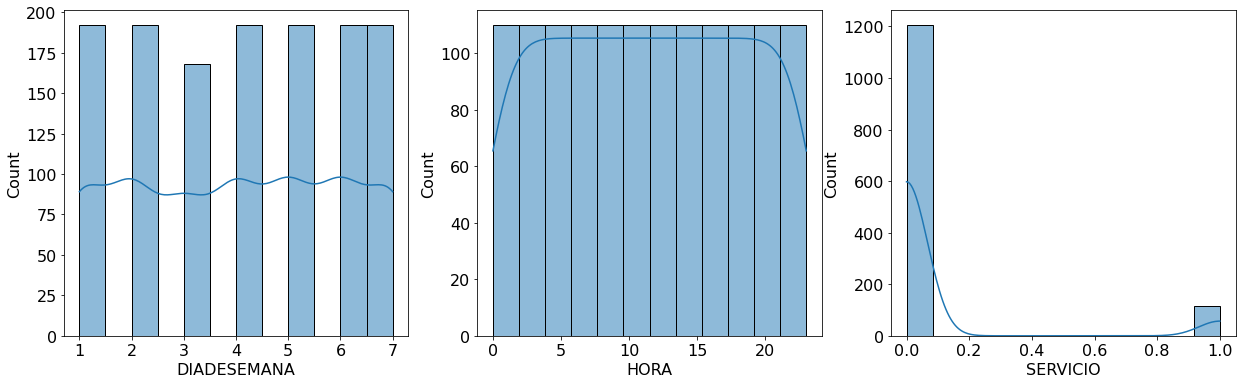

Coeficientes del modelo: [[-0.19148897  0.15634491]]

Intresección del modelo: [-3.87312184]

Número de coeficientes del modelo: 1



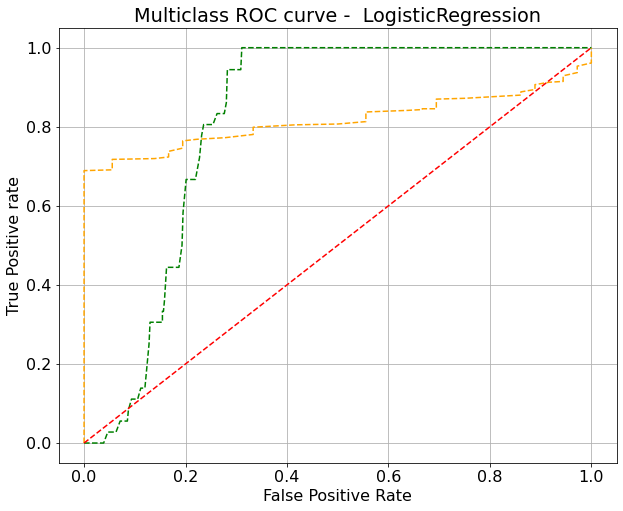

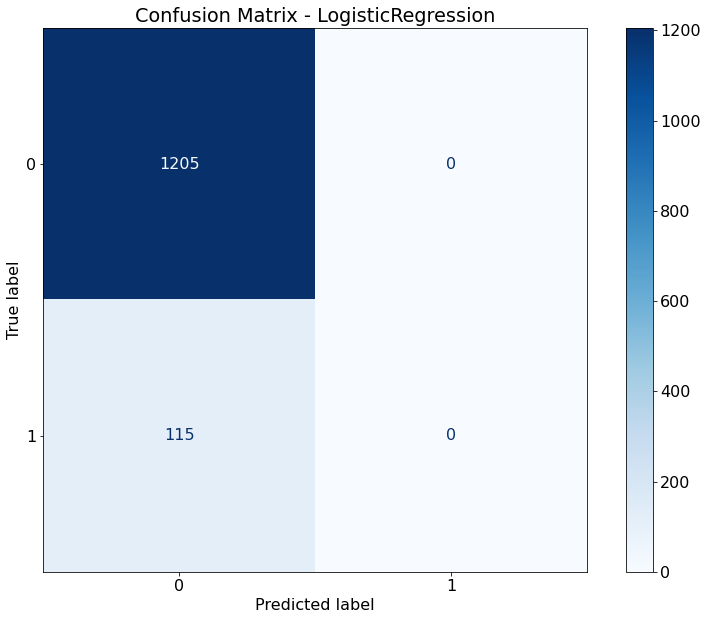

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


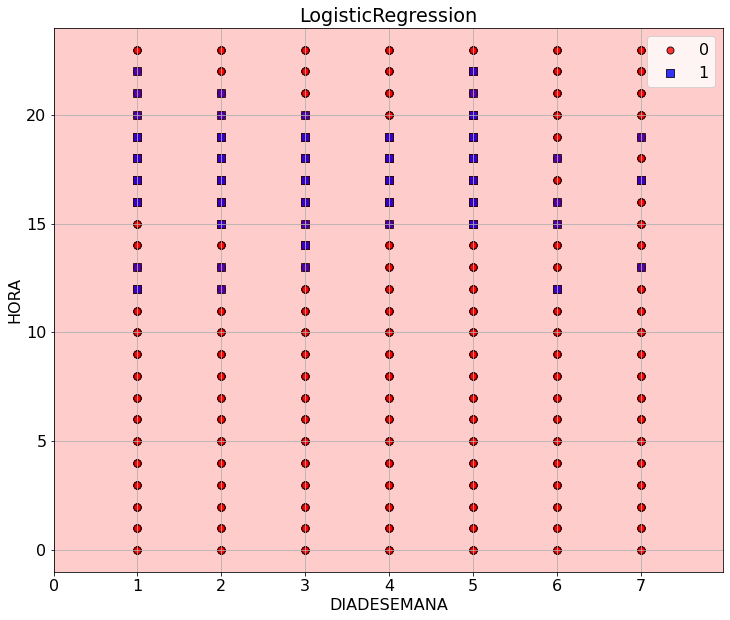

In [512]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'LR')

Experimento con el modelo de KNN

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


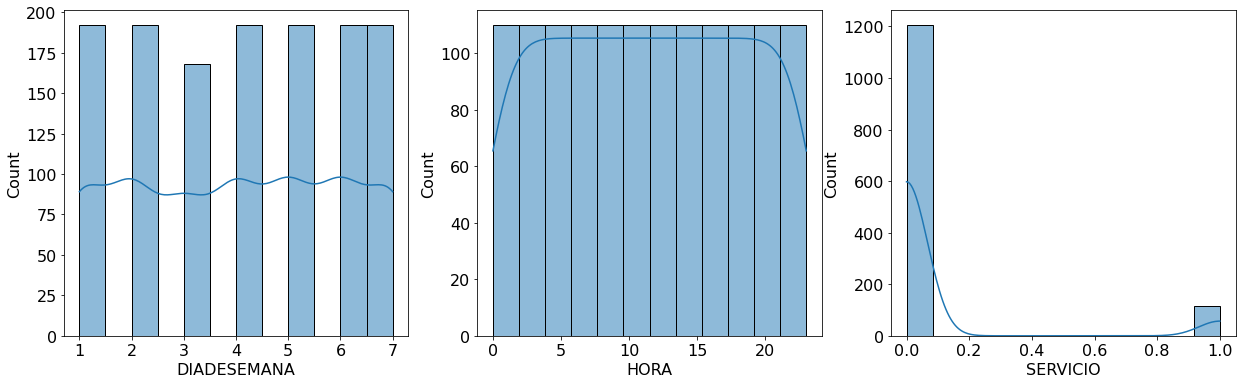

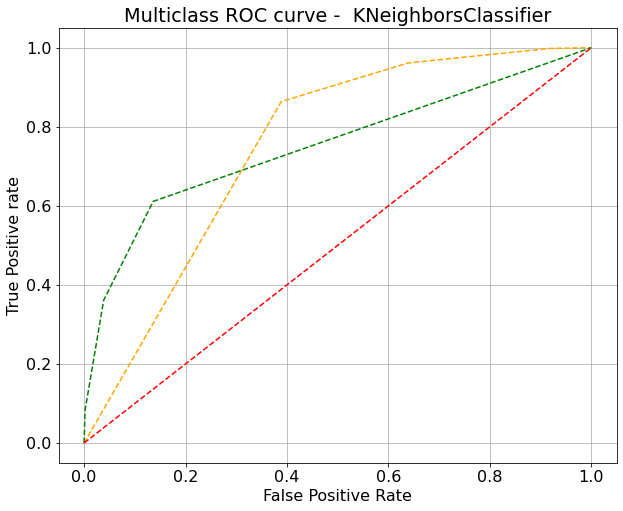

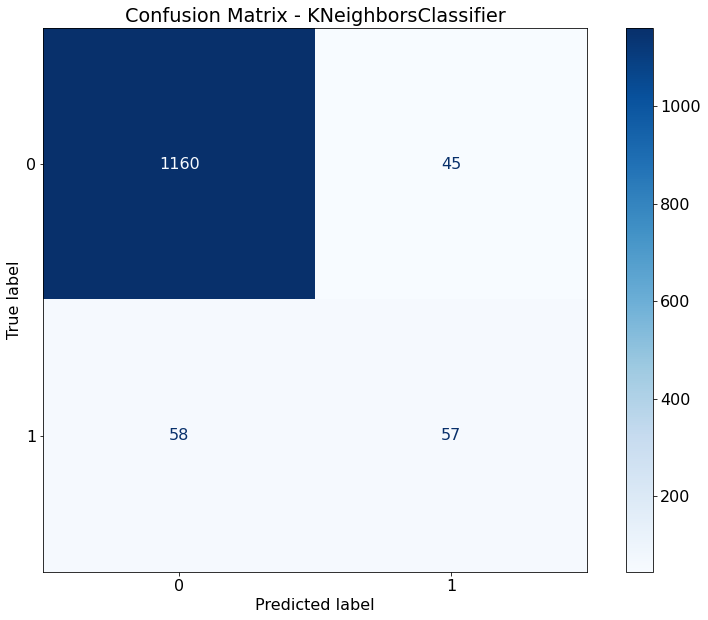

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


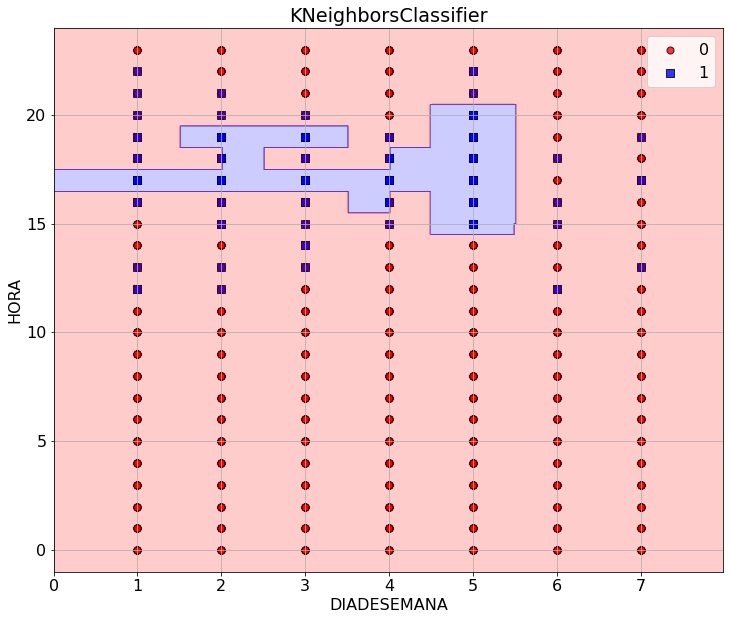

In [513]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'KNN')

Experimento con el modelo de perceptron multicapa

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


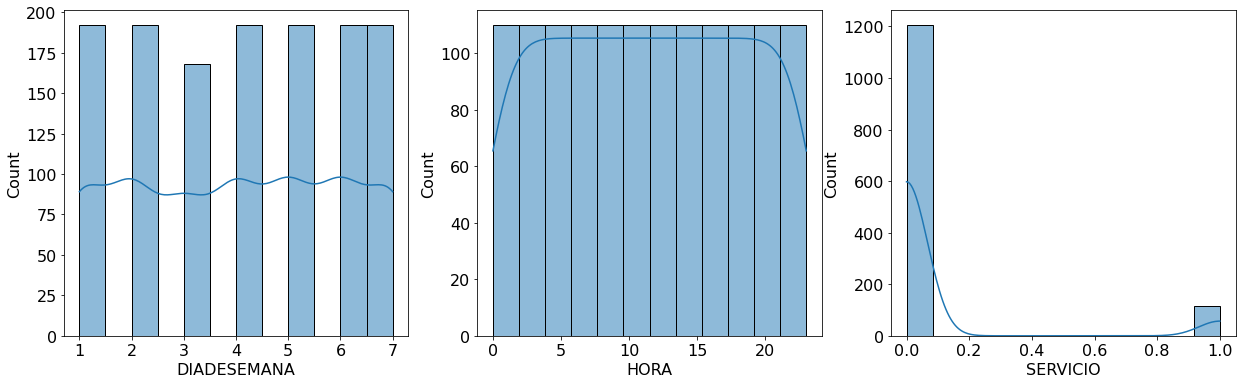

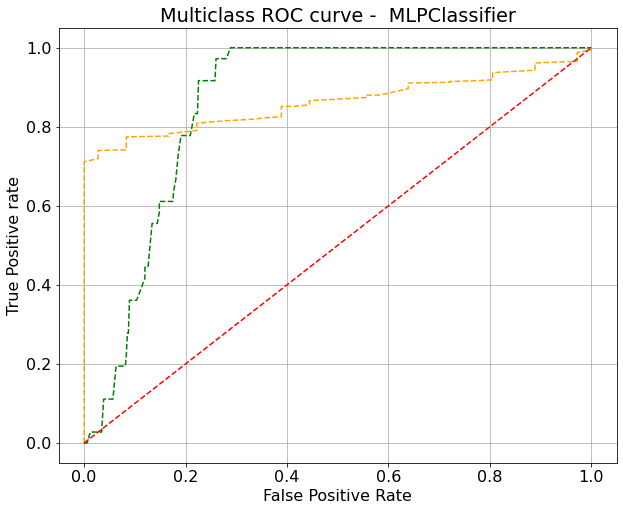

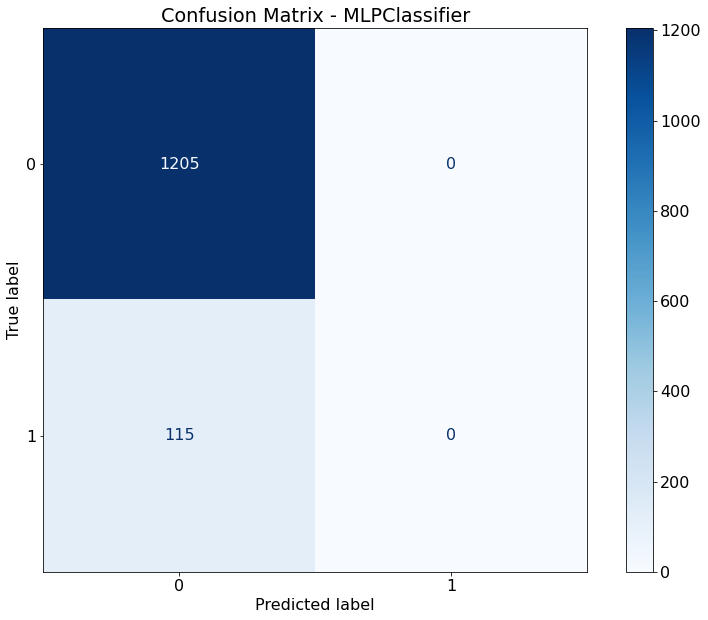

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


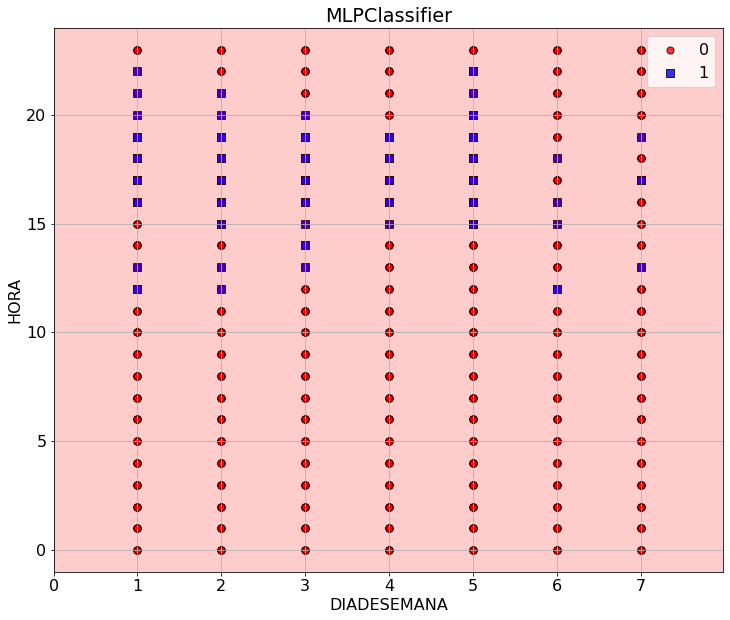

In [515]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'MLP')

Experimento con el modelo de arboles aleatorios

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


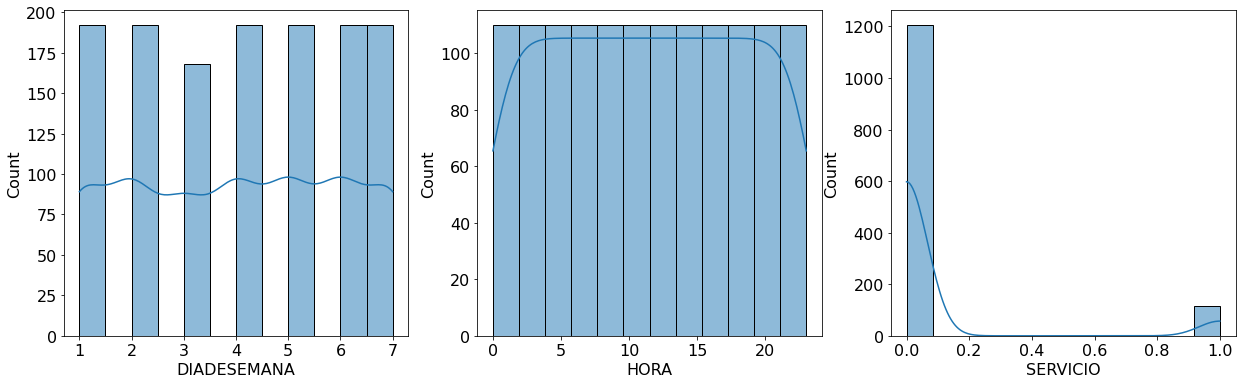

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


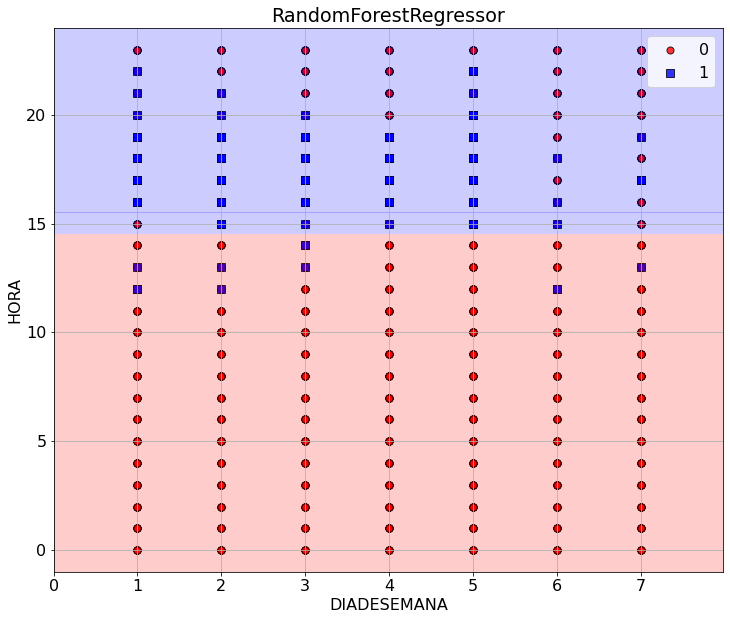

In [516]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'RF')

Experimento con el modelo de clsasificacón con máquina de vector de soporte

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


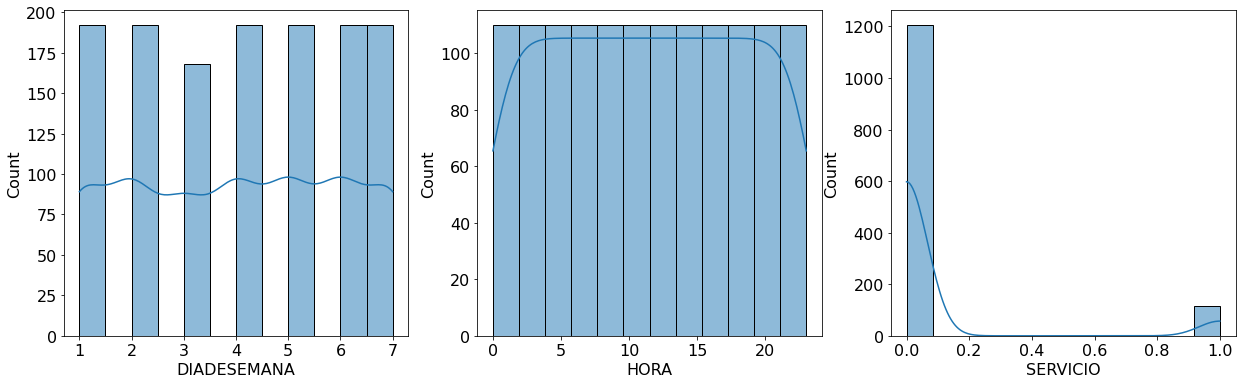

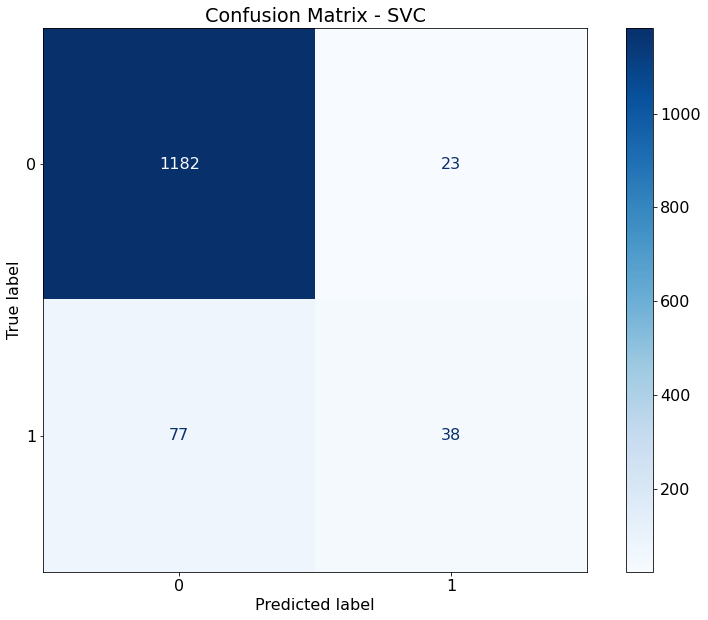

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


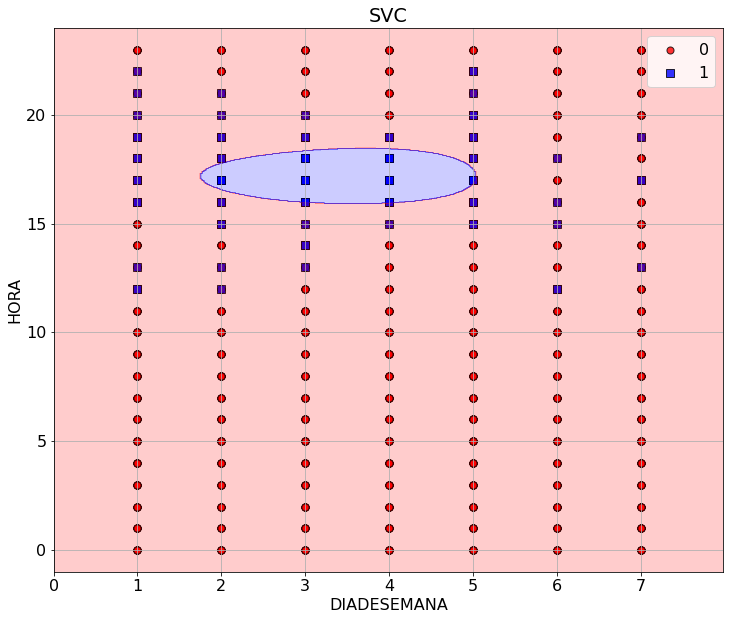

In [519]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'SVC')

Experimento con el modelo de clsasificacón con arboles de decisión

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


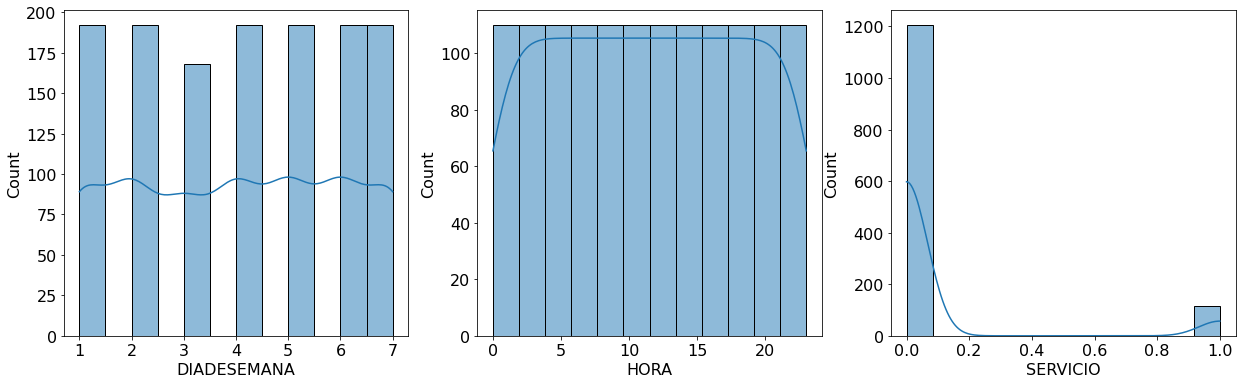

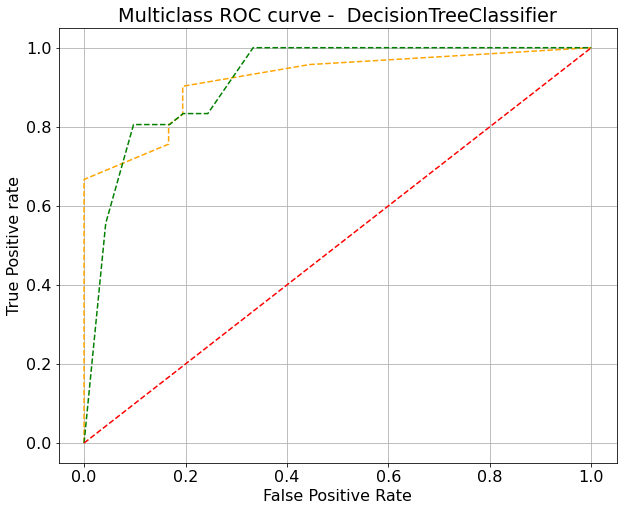

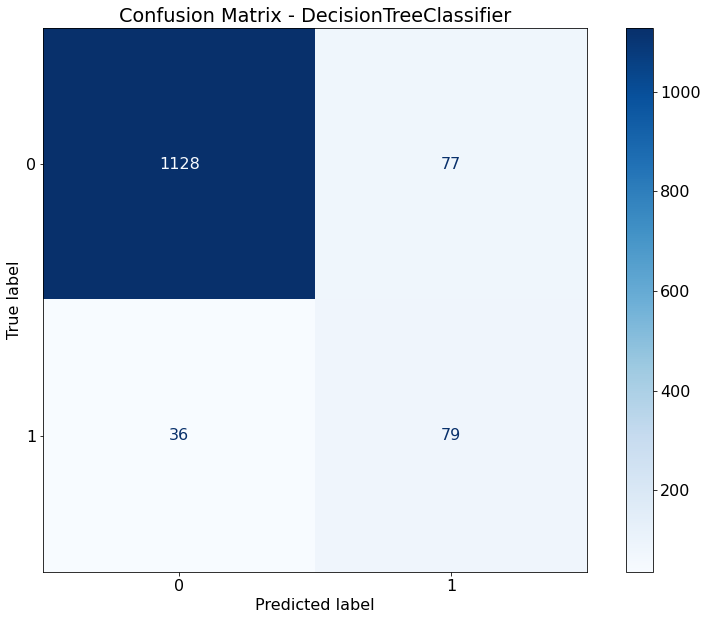

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


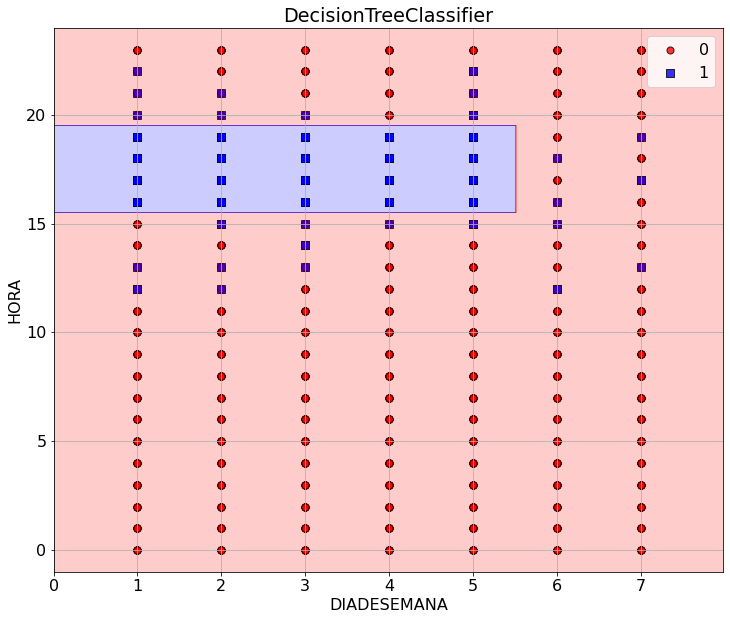

In [520]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'DTC')

In [230]:
def calculateProbability(hour, day, data):
  data_array = data.to_numpy()

  first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  remaining_days = first.date() - last.date()
  #print("First:",first,", last:",last,", remaining:",remaining_days)
  total = 0 
  for i in range(remaining_days.days):
    last_time = last + timedelta(days=i)
    if last_time.isoweekday() == day:
      total += 1
  
  total_onset = 0
  for row in data_array:
    if( ( row[1] == day ) & ( row[2] == hour ) & ( row[4] == 1 ) ):
      total_onset += 1
  
  #print("Total:",total,",Total onset:",total_onset)
  if total > 0:
    return total_onset / total
  else:
    return 0

In [98]:
'''def calculateProbabilisticModel(dataFrame):
  array_date_of_week = []
  for day in range(DAYS_OF_WEEK):
    array_hours = []
    for hour in range(HOURS_OF_DAY):
      array_hours.append( calculateProbability(hour, day+1, dataFrame))
    array_date_of_week.append(array_hours)
  return pd.DataFrame(np.array(array_date_of_week),
                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()'''

'def calculateProbabilisticModel(dataFrame):\n  array_date_of_week = []\n  for day in range(DAYS_OF_WEEK):\n    array_hours = []\n    for hour in range(HOURS_OF_DAY):\n      array_hours.append( calculateProbability(hour, day+1, dataFrame))\n    array_date_of_week.append(array_hours)\n  return pd.DataFrame(np.array(array_date_of_week),\n                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()'

# Probando con función probabilistica

In [232]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print("Processing...",data_row[0])
    
    date_finish_test = DATE_START_TRAINIG + timedelta(days=1)
    days_of_test = date_finish_test.date() - DATE_START_TRAINIG.date()
    print("From: ",DATE_START_TRAINIG, ", To: ",date_finish_test, ", Remaning: ",days_of_test)
    array_date_of_week = []
    for i in range(days_of_test.days):
        date_training = DATE_START_TRAINIG + timedelta(days=i)
        date_last_training = date_training - timedelta(weeks=NUM_OF_WEEK)
        print("------------------------------------------")
        #print("date trainig: ",date_training, " - last trainig: ", date_last_training, " remaninig:", date_training.date() - date_last_training.date())

        #Se filtran los datos para el número de teléfono
        data_user = df_cleaned[df_cleaned["TELEFONOORIGEN"]==data_row[0]].copy()
        
        df_train = data_user[ (pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) < date_training) & (pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) > date_last_training) ]
        df_test = data_user[(pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) == date_training) & (data_user['DIADESEMANA'] == date_training.isoweekday()) ]
        #df_train = data_user.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > 1)
        
        print("Real using")
        print( df_test.to_numpy() )
        print("Model prediction")
        if len(df_train) > 0:
            train = preparingDataService(df_train, date_last_training, date_training, data_row[0])
            array_hours = []
            for hour in range(HOURS_OF_DAY):
                prob = calculateProbability(hour, date_training.isoweekday(), train)
                if (prob >= 0.7):
                    print("[",data_row[0],",",date_training.isoweekday(),",",hour,",",date_training,",",prob,"]")
                #array_hours.append( [date_predict.isoweekday(),hour,prob] )
            #array_date_of_week.append(array_hours)
        else:
            print("User doesn't have information")
    #print(array_date_of_week)

Processing... 3115590650
From:  2022-04-27 00:00:00 , To:  2022-04-28 00:00:00 , Remaning:  1 day, 0:00:00
------------------------------------------
Real using
[['3115590650' 3 15 '2022-04-27' 4]
 ['3115590650' 3 16 '2022-04-27' 4]
 ['3115590650' 3 17 '2022-04-27' 4]
 ['3115590650' 3 18 '2022-04-27' 4]]
Model prediction
Total valor: 115, total: 1368


Se muestra la probabilidad de un usuario con los datos de entrenamiento

In [ ]:
'''def calculateProbabilisticModel(dataFrame):
  array_date_of_week = []
  for day in range(DAYS_OF_WEEK):
    array_hours = []
    for hour in range(HOURS_OF_DAY):
      array_hours.append( calculateProbability(hour, day+1, dataFrame))
    array_date_of_week.append(array_hours)
  return pd.DataFrame(np.array(array_date_of_week),
                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()'''

'def calculateProbabilisticModel(dataFrame):\n  array_date_of_week = []\n  for day in range(DAYS_OF_WEEK):\n    array_hours = []\n    for hour in range(HOURS_OF_DAY):\n      array_hours.append( calculateProbability(hour, day+1, dataFrame))\n    array_date_of_week.append(array_hours)\n  return pd.DataFrame(np.array(array_date_of_week),\n                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()'

Se prueba con los datos de entrenamiento

In [ ]:
#calculateProbabilisticModel(train)

Se valida con los datos de pruebas

In [ ]:
#calculateProbabilisticModel(test)

# Exploración inicial

In [ ]:
'''df_reg = df_mp.copy()
df_reg = df_reg.drop(columns=['TELEFONOORIGEN','FECHA'])
fig, axes = plot.subplots(1, 3)
fig.set_size_inches(21,6)
for i, column in enumerate(df_reg.columns):
  sns.histplot(df_reg[column], kde=True, ax=axes[i])'''

"df_reg = df_mp.copy()\ndf_reg = df_reg.drop(columns=['TELEFONOORIGEN','FECHA'])\nfig, axes = plot.subplots(1, 3)\nfig.set_size_inches(21,6)\nfor i, column in enumerate(df_reg.columns):\n  sns.histplot(df_reg[column], kde=True, ax=axes[i])"

Se genera un diagrama de dispersión

In [ ]:
'''served = df_reg[df_reg.SERVICIO == 1]
not_served = df_reg[df_reg.SERVICIO == 0]

plot.figure(figsize=(14, 8))
plot.plot(served['DIADESEMANA'].values, served['HORA'].values, linestyle='', marker='o', color='royalblue', label='Served')
plot.plot(not_served['DIADESEMANA'].values, not_served['HORA'].values, linestyle='', marker='x', color='r', label='Not Served')
plot.title("Services results")
plot.legend()
plot.grid()
plot.xlabel('Dia de la semana')
plot.ylabel('Hora')
plot.show()'''

'served = df_reg[df_reg.SERVICIO == 1]\nnot_served = df_reg[df_reg.SERVICIO == 0]\n\nplot.figure(figsize=(14, 8))\nplot.plot(served[\'DIADESEMANA\'].values, served[\'HORA\'].values, linestyle=\'\', marker=\'o\', color=\'royalblue\', label=\'Served\')\nplot.plot(not_served[\'DIADESEMANA\'].values, not_served[\'HORA\'].values, linestyle=\'\', marker=\'x\', color=\'r\', label=\'Not Served\')\nplot.title("Services results")\nplot.legend()\nplot.grid()\nplot.xlabel(\'Dia de la semana\')\nplot.ylabel(\'Hora\')\nplot.show()'

In [ ]:
#df_reg[['DIADESEMANA','HORA']].boxplot(figsize=(14,9))

Generando datos de prueba y entrenamiento

In [ ]:
#CONJUNTO DE DATOS DE PRUEBA (20%)
'''
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_reg, test_size=0.2, random_state=3, shuffle=True)
print(train)'''

'\nfrom sklearn.model_selection import train_test_split\ntrain, test = train_test_split(df_reg, test_size=0.2, random_state=3, shuffle=True)\nprint(train)'

In [ ]:
#datos de entrenamiento
#train.shape

In [ ]:
#Matriz de Dispersion con MatPlotLib
#pd.plotting.scatter_matrix(train.loc[:,['DIADESEMANA','HORA','SERVICIO']], figsize=(14,10), alpha=0.8)
#plot.show()

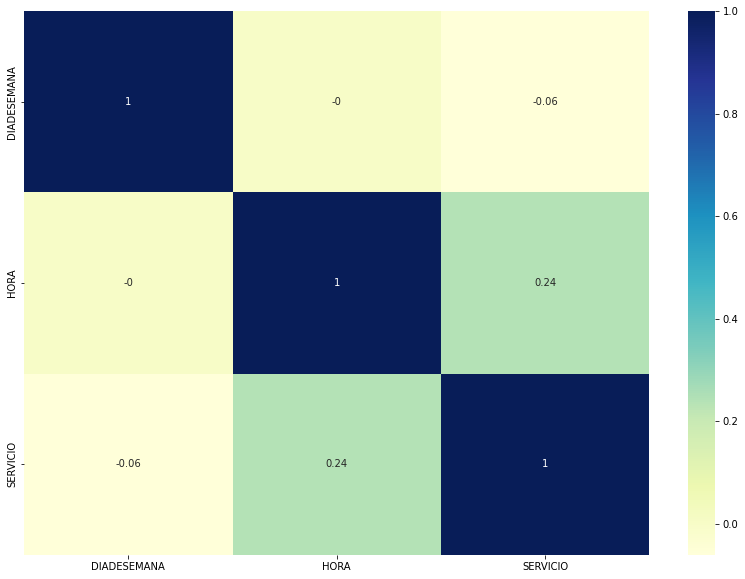

In [ ]:
correlation_matrix = train.corr().round(2) 
fig, heat = plot.subplots(figsize = (14,10))
heat = sns.heatmap(data=correlation_matrix, annot=True, cmap="YlGnBu")
plot.show()

In [ ]:
#train.corr().SERVICIO.to_frame()

# Generación del modelo

ALGORITMO DE LOS KNN